In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

from pylab import rcParams


df = pd.read_csv('/content/athlete_events.csv')

In [31]:
# Preprocessing Data

def extract_year(val):
    year=val[:val.index(' ')]
    year=int(year)
    return year

def extract_season(val):
    season=val[val.index(' ')+1:]
    return season

def figure(b,l):
    rcParams['figure.figsize']=(b,l)

df['Year']=df['Games'].apply(extract_year)
df['Season']=df['Games'].apply(extract_season)
df.drop('Games',axis=1,inplace=True)

df['Medal']=df['Medal'].fillna('None')
medal_dummies=pd.get_dummies(df['Medal'],prefix='Medal')
df=pd.concat([df,medal_dummies],axis=1)
df=df.drop('Medal',axis=1)

In [32]:
city_map={
(1896,'Athina'):'GRE', (1900,'Paris'):'FRA', (1904,'St. Louis'):'USA', 
(1906,'Athina'):'GRE', (1908,'London'):'GBR', (1912,'Stockholm'):'SWE', 
(1920,'Antwerpen'):'BEL', (1924,'Chamonix'):'FRA', (1924,'Paris'):'FRA',
(1928,'Amsterdam'):'NED', (1928,'Sankt Moritz'):'SUI', (1932,'Lake Placid'):'USA',
 (1932,'Los Angeles'):'USA', (1936,'Berlin'):'GER', (1936,'Garmisch-Partenkirchen'):'GER',
(1948,'London'):'GBR', (1948,'Sankt Moritz'):'SUI', (1952,'Helsinki'):'FIN',
(1952,'Oslo'):'NOR', (1956,"Cortina d'Ampezzo"):'ITA', (1956,'Melbourne'):'AUS',
(1956,'Stockholm'):'SWE', (1960,'Roma'):'ITA', (1960,'Squaw Valley'):'USA',
(1964,'Innsbruck'):'AUT', (1964,'Tokyo'):'JPN', (1968,'Grenoble'):'FRA',
(1968,'Mexico City'):'MEX', (1972,'Munich'):'FRG', (1972,'Sapporo'):'JPN',
(1976,'Innsbruck'):'AUT', (1976,'Montreal'):'CAN', (1980,'Lake Placid'):'USA',
(1980,'Moskva'):'URS', (1984,'Los Angeles'):'USA', (1984,'Sarajevo'):'YUG',
(1988,'Calgary'):'CAN', (1988,'Seoul'):'KOR', (1992,'Albertville'):'FRA', 
(1992,'Barcelona'):'ESP', (1994,'Lillehammer'):'NOR', (1996,'Atlanta'):'USA',
(1998,'Nagano'):'JPN', (2000,'Sydney'):'AUS', (2002,'Salt Lake City'):'USA',
(2004,'Athina'):'GRE', (2006,'Torino'):'ITA', (2008,'Beijing'):'CHN',
(2010,'Vancouver'):'CAN', (2012,'London'):'GBR', (2014,'Sochi'):'RUS',
(2016,'Rio de Janeiro'):'BRA'
}

# Ser anfitrião dos Jogos (Inverno e Verão) faz com que o país ganhe mais medalhas?

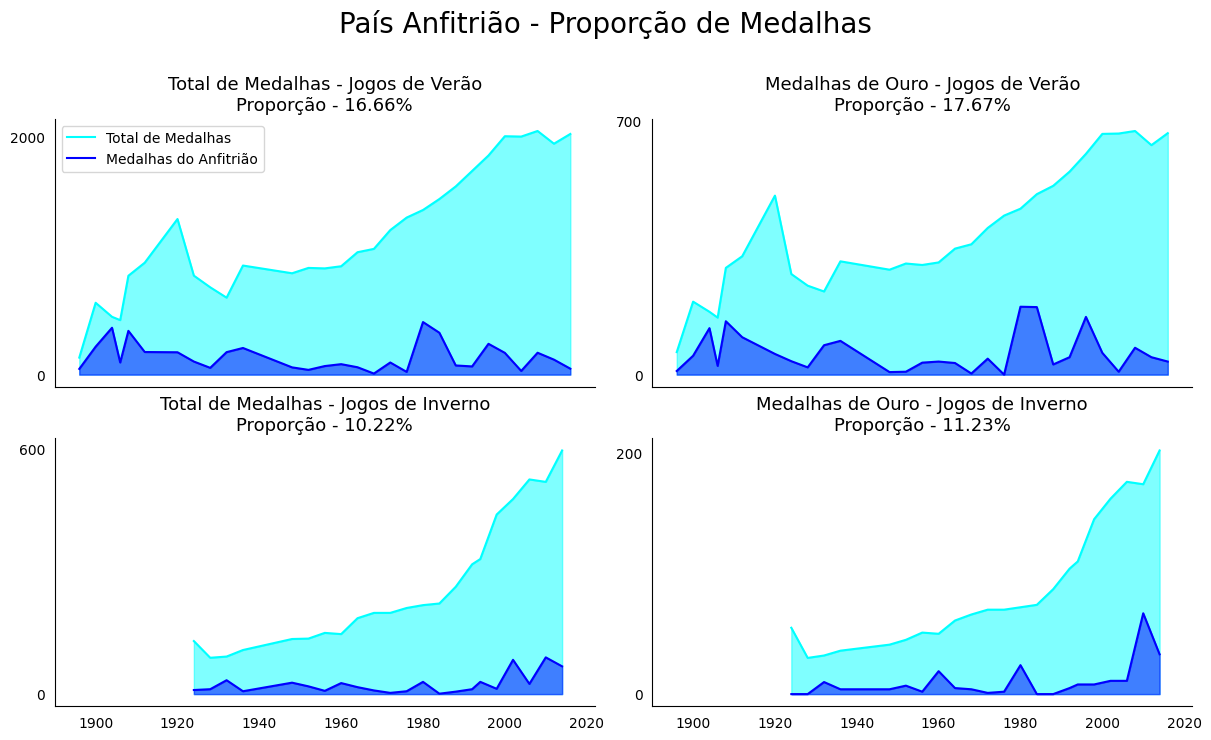

In [33]:
host_years=[]
host_city=[]
host_NOC=[]

for key in city_map:
    host_years.append(key[0])
    host_city.append(key[1])
    host_NOC.append(city_map[key])
host_NOC=pd.DataFrame.from_dict({'Year':host_years,'City':host_city,'Host_NOC':host_NOC})
data=df.join(host_NOC.set_index(['Year','City']),on=['Year','City'])
data['Is_Host']=pd.Series(data['NOC']==data['Host_NOC'],index=data.index)
data['Is_Host']=data['Is_Host'].map({True:1,False:0})


def extract_medal_tally(data):
    medal_data=data.groupby(['Year','City','Host_NOC','NOC'])[['Medal_Gold','Medal_Silver','Medal_Bronze']].aggregate('sum').reset_index()
    total_data=medal_data.groupby(['Year'])[['Medal_Gold','Medal_Silver','Medal_Bronze']].aggregate('sum').reset_index()
    host_data=medal_data[medal_data['Host_NOC']==medal_data['NOC']]
    host_data=host_data.groupby(['Year'])[['Medal_Gold','Medal_Silver','Medal_Bronze']].aggregate('sum').reset_index()
    host_data['Total_Medals']=host_data.apply(lambda x:x['Medal_Gold']+x['Medal_Silver']+x['Medal_Bronze'],axis=1)
    total_data['Total_Medals']=total_data.apply(lambda x:x['Medal_Gold']+x['Medal_Silver']+x['Medal_Bronze'],axis=1)
    return total_data,host_data

summer_data=data[data['Season']=='Summer'].reset_index(drop=True)
summer_total_data,summer_host_data=extract_medal_tally(summer_data)

winter_data=data[data['Season']=='Winter'].reset_index(drop=True)
winter_total_data,winter_host_data=extract_medal_tally(winter_data)

figure(12,7)
fig,ax=plt.subplots(2,2,constrained_layout=True,sharex=True)
fig.suptitle("País Anfitrião - Proporção de Medalhas",fontsize=20,va='bottom')


datas=[
    (summer_total_data['Total_Medals'],summer_host_data['Total_Medals']),
    (summer_total_data['Medal_Gold'],summer_host_data['Medal_Gold']),
    (winter_total_data['Total_Medals'],winter_host_data['Total_Medals']),
    (winter_total_data['Medal_Gold'],winter_host_data['Medal_Gold'])
]

titles=[
    'Total de Medalhas - Jogos de Verão',
    'Medalhas de Ouro - Jogos de Verão',
    'Total de Medalhas - Jogos de Inverno',
    'Medalhas de Ouro - Jogos de Inverno',

]

ticks=[2000,700,600,200]

summer_years=summer_total_data['Year']
winter_years=winter_total_data['Year']
years=[summer_years,summer_years,winter_years,winter_years]

for index in np.arange(4):
    row=int(index/2);col=int(index%2)
    ax[row,col].plot(years[index],datas[index][0],color='cyan',label='Total de Medalhas')
    ax[row,col].plot(years[index],datas[index][1],color='blue',label='Medalhas do Anfitrião')
    perc=np.divide(datas[index][1],datas[index][0])*100
    perc=np.mean(perc)
    ax[row,col].fill_between(x=years[index],y1=datas[index][0],color='cyan',alpha=0.5)
    ax[row,col].fill_between(x=years[index],y1=datas[index][1],color='blue',alpha=0.5)
    ax[row,col].spines['top'].set_visible(False)
    ax[row,col].spines['right'].set_visible(False)
    ax[row,col].tick_params(bottom=False,left=False)
    ax[row,col].set_title(titles[index]+'\nProporção - {perc:.2f}%'.format(perc=perc),fontsize=13)
    ax[row,col].yaxis.set_major_locator(ticker.MultipleLocator(ticks[index]))
    ax[row,col].yaxis.grid(False)
    if(index==0):
        ax[row,col].legend(loc='best')

plt.show()

Devemos ressaltar aqui que os Jogos de inverno passaram a ser organizados depois dos jogos de verão, por esse motivo os graficos dos primeiros tem início no eixo x diferente. Também é interessante lembrar que, até determinado ponto, ambas as temporadas aconteciam no memso ano, mas depois passam a se alternar de dois em dois anos.

 Os países que foram anfitriões dos Jogos de Inverno parecem ter muito menos medalhas do que os que foram anfitriões dos Jogos de Verão. A distância entre as linhas ciano e azul indicam a proporção de medalhas conseguidas pelo país anfitrião. A partir disso, é possível observar um declínio na quantidade de medalhas conseguidas pela nação anfitriã, se comparada a quantidade total de medalhas, em cada edição dos jogos com o passar dos anos.